# Aggregate VSI per cell

Here, we will demonstrate the workflow how to aggregate the VSI information for a cell from all its associated pixels in the _ovrlpy_ analysis using a Xenium dataset, but conceptually this works the same for other imaging-based SRT platforms, as well.

In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

import ovrlpy

matplotlib.rc("font", size=6)

data_folder = Path("path/to/data")

We start by reading the transcript data and running the _ovrlpy_ pipeline. Of course the parameters used here can be adjusted to your needs.

Importantly, we additionally load the column mapping transcripts to cell-IDs. This is necessary for one of the approaches and will be explained in the corresponding section. 

In [ ]:
transcripts = ovrlpy.io.read_Xenium(
    data_folder / "transcripts.parquet",
    additional_columns=["cell_id"],
)

brain = ovrlpy.Ovrlp(transcripts, n_workers=8, random_state=42)
brain.analyse(min_transcripts=20)

## Aggregate VSI per cell

### via transcripts

When using the assignments from transcripts to cells, we need to make sure that the corresponding column is already included before we run the _ovrlpy_ pipeline. The functions in {py:mod}`ovrlpy.io` module support reading more than just the transcript coordinate columns with the `additional_columns` argument.
Two details are required when trying to extract the VSI and signal strength values using this method: the name of the column with the transcript to cell asignment, and the value that corresponds to _unassigned_ transcripts. 
- Xenium and MERSCOPE: Typically, the column is named `'cell_id'` and unassigned transcripts are indicated with `-1`.
- CosMx: There is no column uniquely identifying a cell but the combination of  `'cell_ID'` and `'fov'` can be used. The unassigned transcripts are indicated with `0` for the `'cell_ID'`.

This appraoch is easy and fast, however, depending on the sparsity of the data some pixels corresponding to a cell may be missed if they do not have any associated transcripts.

Using the {py:func}`ovrlpy.cell_integrity_from_transcripts` functions we can now obtain the signal strength and VSI per cell. We actually get multiple values (one per pixel) that can be used for further analysis.

In [3]:
cell_pixels = ovrlpy.cell_integrity_from_transcripts(
    brain, cell_id="cell_id", unassigned=-1
)

cell_pixels.head()

cell_id,x_pixel,y_pixel,signal,vsi
i32,i32,i32,f32,f32
114141,5674,2389,0.836131,0.704874
114064,5480,2233,0.316398,0.438043
73743,8215,6233,1.564292,0.609592
27878,1326,3683,0.796194,0.839414
14921,2186,5415,2.458118,0.775897


### via segmentation masks

Instead of using the transcipt to cell assignments, we can also use the segmentation masks to aggregate the VSI and signal strength per cell.

For this we need two pieces of information, a segmentation mask per cell (as a [`shapely` Geometry](https://shapely.readthedocs.io/page/geometry.html), typically a Polygon), and a cell-ID.

Note, that for this approach we need additional optional dependencies that can be installed via the ovrlpy extra

```sh
pip install ovrlpy[segmentation]
```

Below you can find example code on how to generate this information from the standard output of some of the widely adopted platforms.

#### Examples how to load segmentation masks

##### Xenium

In [4]:
from shapely.geometry import Polygon

boundary_file = data_folder / "cell_boundaries.parquet"


boundaries = (
    pl.scan_parquet(boundary_file)
    .select("cell_id", pl.concat_arr(["vertex_x", "vertex_y"]).alias("coords"))
    .group_by("cell_id")
    .agg(pl.col("coords"))
    .with_columns(
        pl.col("coords").map_elements(Polygon, return_dtype=pl.Object).alias("mask")
    )
    .collect()
)

masks = boundaries["mask"]
ids = boundaries["cell_id"]

##### MERSCOPE

In [ ]:
import geopandas as gpd  # geopandas must be installed separately
from shapely import union_all

boundary_file = data_folder / "cell_boundaries.parquet"


boundaries = (
    gpd.read_parquet(boundary_file, columns=["EntityID", "Geometry"])
    # get union across all z-planes as we only need a single 2D cell mask
    # though its also possible to select a single z-plane instead
    .groupby("EntityID")
    .aggregate({"Geometry": union_all})
    .set_geometry("Geometry")
)

masks = boundaries["Geometry"]
ids = boundaries.index

##### CosMx

In [ ]:
import polars.selectors as cs
from shapely.geometry import Polygon

boundary_file = data_folder / "S0-polygons.csv.gz"

boundaries = (
    pl.read_csv(
        boundary_file,
        columns=["cell", "x_global_px", "y_global_px"],
        schema_overrides={
            "cell": pl.Categorical,
            # Due to weird encoding of the coordinates in the csv (using scientific notation)
            # they could only be parsed as floats (even if they are actually integers)
            # and then needed to be cast to integer.
            # This may not be necessary for all datasets.
            "x_global_px": pl.Float32,
            "y_global_px": pl.Float32,
        },
    )
    .lazy()
    .with_columns(cs.numeric().cast(pl.Int32))  # see comment above
    .with_columns(pl.concat_arr(["x_global_px", "y_global_px"]).alias("coords"))
    .group_by("cell")
    .agg(pl.col("coords"))
    .filter(pl.col("coords").list.len() >= 3)  # remove invalid polygons
    .with_columns(
        pl.col("coords").map_elements(Polygon, return_dtype=pl.Object).alias("mask")
    )
    .collect()
)


masks = boundaries["mask"]
ids = boundaries["cell"]

Using the segmentation masks and the cell-IDs we can aggregate the VSI and signal to obtain a similar DataFrame as before.

In [5]:
cell_pixels = ovrlpy.cell_integrity_from_masks(brain, masks, ids)

cell_pixels.head()

cell_id,x_pixel,y_pixel,signal,vsi
i32,i64,i64,f32,f32
16712,3960,28,1.330162,0.901204
16712,3961,28,1.138057,0.734445
16712,3959,29,1.26439,0.944789
16712,3960,29,1.1826,0.913471
16712,3961,29,1.004933,0.72393


## Filtering low VSI cells

### Defining low-quality cells

There are multiple ways that come to mind how the VSI and signal values per cell can be analysed. We haven't benchmarked these yet but some ideas are listed below.

In general we would recommend to filter the pixels by a minimum signal strength cutoff to avoid effects of pixels with low gene expression which are therefore likely noisy. The exact value depends on your dataset and is influenced by parameters such as the gene panel (highly vs lowly expressed genes), the panel size, sensitivity, ...

Similarly, the VSI threshold depends on the analysed samples and should be evaluated and carefully picked. Here, we will use a value 0.7 as threshold.

In [6]:
min_s = 1.5  # signal strength threshold
min_vsi = 0.7  # VSI threshold

cell_pixels = cell_pixels.filter(pl.col("signal") > min_s)

One idea is to evaluate cells based on the fraction of the area (here using pixels as proxy) that is affected by low vertical signal integrity. A reasonable threshold for the VSI may depend on your experiment.

In [7]:
fraction_of_low_vsi_per_cell = cell_pixels.group_by("cell_id").agg(
    fraction_low_vsi_px=(pl.col("vsi") < min_vsi).sum() / pl.col("vsi").len()
)

fraction_of_low_vsi_per_cell.head()

cell_id,fraction_low_vsi_px
i32,f64
115370,0.0390625
47595,0.079365
108019,0.0
45237,0.100917
61609,0.065574


Another option is to calculate the mean VSI per cell.

In [8]:
mean_vsi_per_cell = cell_pixels.group_by("cell_id").agg(pl.col("vsi").mean())

mean_vsi_per_cell.head()

cell_id,vsi
i32,f32
148927,0.901035
141567,0.894772
42608,0.878738
5121,0.829888
143684,0.826892


### Filtering cells

To demonstrate the effect of low VSI cells (using these two measures) we will visualize the calculated metrics per cell in a UMAP and see what happens if we remove them.

In [9]:
# to avoid cluttering the output with warnings

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

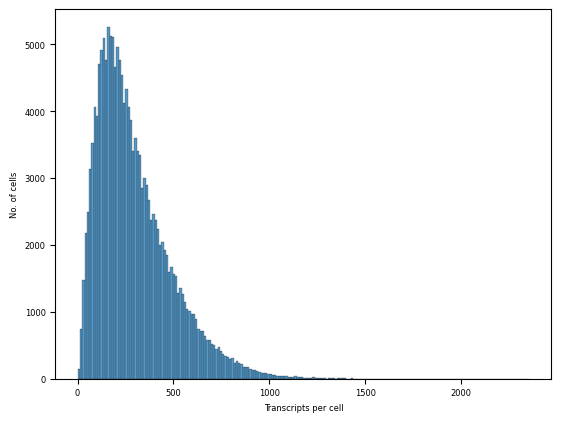

In [10]:
import scanpy as sc

cells = sc.read_10x_h5(data_folder / "cell_feature_matrix.h5")

ax = sns.histplot(cells.X.sum(axis=1).A1, bins=200)
_ = ax.set(xlabel="Transcripts per cell", ylabel="No. of cells")

We will just perform some minimal filtering of the cells and very basic processing for the demonstration. Of course you can adjust this workflow to your liking.

In [11]:
sc.pp.filter_cells(cells, min_counts=50)
sc.pp.filter_cells(cells, max_counts=1_000)

sc.pp.pca(cells, n_comps=30)
sc.pp.neighbors(cells)
sc.tl.umap(cells, min_dist=0.1)

Next, we will add the calculated metrics as metadata to our cells.

In [12]:
# transform to pandas.DataFrame and make the index a string (necessary for AnnData)
metrics = (
    mean_vsi_per_cell.join(
        fraction_of_low_vsi_per_cell, on="cell_id", how="full", coalesce=True
    )
    .to_pandas()
    .astype({"cell_id": str})
    .set_index("cell_id")
)

# drop cells for which we do not have VSI info
cells = cells[cells.obs_names.isin(metrics.index)]

cells.obs = cells.obs.join(metrics)

And visualize the results of cell filtering in UMAPs.

In [ ]:
from ovrlpy._plotting import BIH_CMAP


def plot_UMAPs(
    umaps, hue, threshold_label, umap_cols=["UMAP1", "UMAP2"], cmap=BIH_CMAP
):
    x, y = umap_cols

    with plt.style.context("dark_background"):
        fig, axs = plt.subplots(
            ncols=5, figsize=(7, 2.2), width_ratios=[1, 1, 1, 1, 0.05]
        )

        scatter_kwargs = dict(
            x=x,
            y=y,
            s=0.1,
            lw=0,
            rasterized=True,
            hue=hue,
            palette=cmap,
            legend=False,
            hue_norm=matplotlib.colors.Normalize(vmin=0, vmax=1),
        )

        for i, (ax, t) in enumerate(zip(axs, umaps)):
            df = umaps[t]
            n = df.shape[0]
            _ = sns.scatterplot(data=df, ax=ax, **scatter_kwargs)
            if i == 0:
                ax.set(title=f"All cells\n({n:,} cells)")
            else:
                threshold = threshold_label.format(t=t)
                ax.set(title=f"Filtered cells\n({threshold}, {n:,} cells)")

            if i == 3:
                m = plt.cm.ScalarMappable(norm=ax.collections[0].norm, cmap=cmap)
                fig.colorbar(m, ax=ax, cax=axs[i + 1], ticks=[0, 1], label=hue)

            ax.set_aspect("equal", adjustable="box")
            ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)
            ax.axis("square")

        fig.tight_layout()

    return fig

#### Mean VSI

First a quick look at the mean VSI distribution, which can help find an appropriate threshold for filtering.

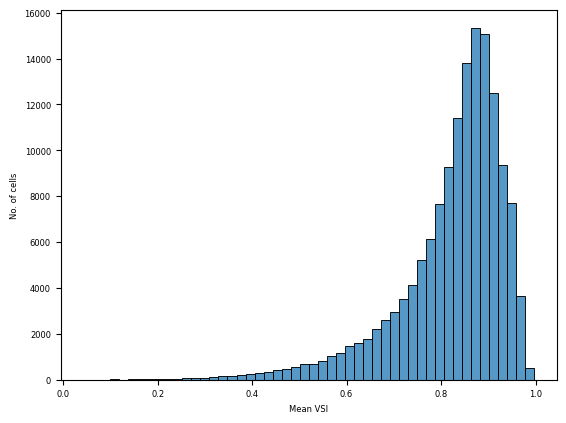

In [14]:
ax = sns.histplot(cells.obs["vsi"], bins=50)
_ = ax.set(xlabel="Mean VSI", ylabel="No. of cells")

In the UMAP we can observe how the separation of clusters has improved by removing these potential doublets. We used a few thresholds to demonstrate the effect.

In [15]:
def calculate_umap(adata):
    sc.pp.pca(adata, n_comps=30)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata, min_dist=0.1)

    df = adata.obs
    df[["UMAP1", "UMAP2"]] = adata.obsm["X_umap"]
    return df

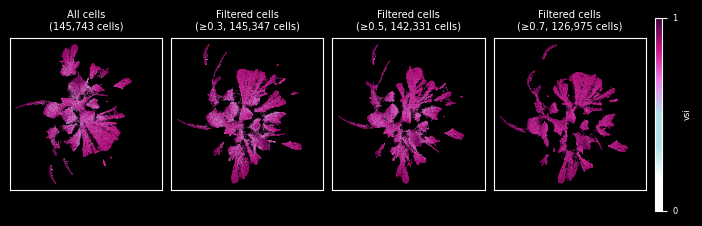

In [16]:
umap = cells.obs.copy()
umap[["UMAP1", "UMAP2"]] = cells.obsm["X_umap"]

umaps = {None: umap}

# define doublets by mean VSI below threshold and generate UMAPs w/o doublets
for t in [0.3, 0.5, 0.7]:
    umaps[f"{t:.1f}"] = calculate_umap(cells[cells.obs["vsi"] >= t].copy())


fig = plot_UMAPs(umaps, hue="vsi", threshold_label="≥{t}")

#### Fraction of low VSI pixels

Following the same procedure as before, we first have a look at the overall distribution of our metric and then decide on a threshold for filtering and show the results in a UMAP.

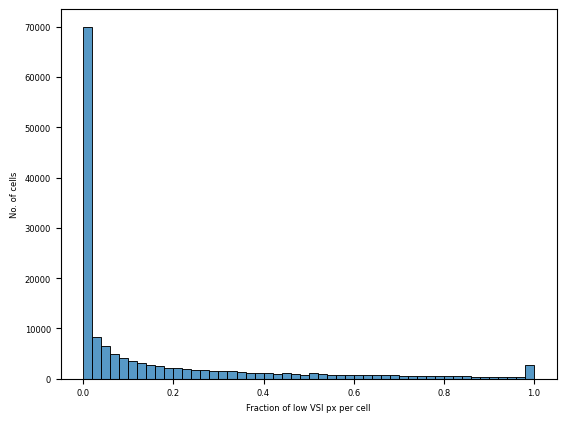

In [17]:
ax = sns.histplot(cells.obs["fraction_low_vsi_px"], bins=50)
_ = ax.set(xlabel="Fraction of low VSI px per cell", ylabel="No. of cells")

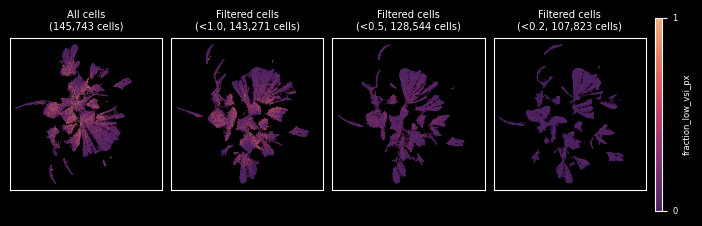

In [19]:
umaps = {None: umap}

# define doublets by more than X% pixels with VSI below threshold
for t in [1, 0.5, 0.2]:
    umaps[f"{t:.1f}"] = calculate_umap(
        cells[cells.obs["fraction_low_vsi_px"] < t].copy()
    )

fig = plot_UMAPs(
    umaps, hue="fraction_low_vsi_px", threshold_label="<{t}", cmap="flare_r"
)